In [39]:
#Importation des bibliotheques
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [40]:
#Chargement d'une image
image = cv2.imread('/home/XPS/Documents/Studies/ProjetTech/RepositoryGitHub/Script/imageFolder/image2.jpeg')

In [41]:
#Transformation de l'image en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [42]:
# Reduction du bruit en utilisant le filtre gaussien
blurred = cv2.blur(gray, (3, 3))

<h1 style="color:Cyan">Ressortir l'otholite du Background</h1>

In [43]:
# Appliquer un seuil simple pour créer un masque pour le premier plan
_, mask = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)

# Inversez le masque pour obtenir l'arrière-plan
mask_inv = cv2.bitwise_not(mask)

# Appliquez le masque à l'image originale pour supprimer l'arrière-plan
foreground = cv2.bitwise_and(image, image, mask=mask)

<h1 style="color:Cyan">Augmenter la visibilité des anneaux</h1>

In [44]:
# Conversion du premier plan en niveaux de gris pour l'égalisation de l'histogramme
foreground_gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
# Augmenter le contraste à l'aide de l'égalisation de l'histogramme
equalized = cv2.equalizeHist(foreground_gray)

<h1 style="color:Cyan">Binarisation de l'image</h1>

In [45]:
# Appliquer un seuil adaptatif pour binariser l'image
binary = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

<h1 style="color:Cyan">Detection des contours</h1>

<h3 style="color:Red">En utilisant la bibliotheque CV2</h3>

In [46]:
# Find contours in the otolith region
otolith_contours, _ = cv2.findContours(equalized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Count the number of rings (contours) in the otolith
num_rings = len(otolith_contours)

# Print the number of rings
print("Number of rings:", num_rings)

# Display the original, foreground, equalized, and binarized images
cv2.imshow('Original', image)
cv2.imshow('Foreground', foreground)
cv2.imshow('Equalized', equalized)
cv2.imshow('Binarized', binary)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of rings: 15


<h3 style="color:Red">En utilisant Les cercles de Hough</h3>

In [47]:
# Apply simple thresholding to create a mask for the foreground
_, mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the largest contour
largest_contour_mask = cv2.drawContours(np.zeros_like(gray), [largest_contour], 0, (255), thickness=cv2.FILLED)

# Apply the mask to the original image to keep only the selected object
selected_object = cv2.bitwise_and(image, image, mask=largest_contour_mask)

# Convert the selected object to grayscale for further processing
selected_object_gray = cv2.cvtColor(selected_object, cv2.COLOR_BGR2GRAY)

# Increase contrast using histogram equalization
equalized = cv2.equalizeHist(selected_object_gray)

# Apply adaptive thresholding to binarize the selected object
binary = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply Hough Circle Transform
circles = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Check if circles were detected
if circles is not None:
    circles = np.uint16(np.around(circles))

    # Draw the detected circles on the selected object image
    for i in circles[0, :]:
        cv2.circle(selected_object, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(selected_object, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center points

cv2.imshow('Selected Object with Circles', selected_object)
cv2.waitKey(0)
cv2.destroyAllWindows()


<h3 style="color:Red">En utilisant La Projection de Mojette</h3>

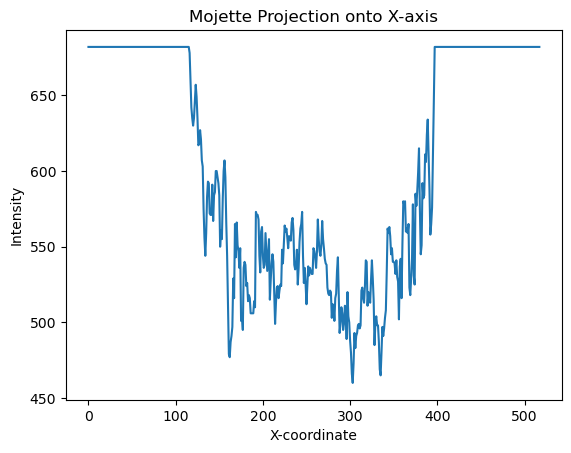

Number of rings: 518


In [48]:
# Mojette's Transformation
def mojette_transform(binarized_image):
    height, width = binarized_image.shape[:2]
    mojette_values = [0] * width
    for x in range(width):
        mojette_values[x] = np.sum(binarized_image[:, x]) // 255
    num_rings = np.sum(np.array(mojette_values) > 0)
    return mojette_values, num_rings

# Perform Mojette's Transformation
mojette_values, num_rings = mojette_transform(binary)

# Plot the Mojette projection onto the x-axis
plt.plot(mojette_values)
plt.title("Mojette Projection onto X-axis")
plt.xlabel("X-coordinate")
plt.ylabel("Intensity")
plt.show()

# Print the number of rings
print("Number of rings:", num_rings)

# Display the selected object and the binarized image
cv2.imshow('Selected Object', selected_object)
cv2.imshow('Binarized Selected Object', binary)
cv2.waitKey(0)
cv2.destroyAllWindows()
